<a href="https://colab.research.google.com/github/BalytskyiJaroslaw/PathogensRamanOpenSet/blob/main/EOS_K_p1_I_p3_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operating in the ***open*** world, Entropic Open Set, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
from numpy import genfromtxt
from sklearn.utils import shuffle


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas import read_csv

from keras.layers import Lambda, Multiply

import csv
import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import keras
#from keras.utils import to_categorical
from pandas import read_csv
from keras.models import Sequential
from keras import layers
#from keras.optimizers import SGD
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
import gspread
import pandas as pd
import pickle
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
#from keras.utils import to_categorical

from time import time
t00 = time()
import os
from tensorflow.keras import layers
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.layers import GlobalAveragePooling1D

In [ ]:
# Initialize the TPU and spread the computations across the 8 cores
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
tf.config.list_logical_devices('TPU')
#print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Reference dataset

In [ ]:
# Reference data
data_X_reference = np.load("/content/gdrive/MyDrive/Stanford_data/X_reference.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_reference = np.load("/content/gdrive/MyDrive/Stanford_data/y_reference.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_reference_int = []

for i in range(data_y_reference.shape[0]):
  data_y_reference_int.append(int(data_y_reference[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_reference_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

# $\mathcal{K} = p_1$, reference indices, training dataset: 18000 - 26000, 34000 - 38000, 44000 - 50000,56000 - 58000. $\mathcal{I} = p_3$, reference indices: 10000 - 14000, 26000 - 28000, 42000 - 44000, 58000 - 60000.

In [ ]:
indices =[slice(18000, 26000),slice(34000, 38000),slice(44000, 50000),slice(56000, 58000),slice(10000, 14000),slice(26000, 28000),slice(42000, 44000),slice(58000, 60000)]

Known_and_Ignored_data_X_reference = np.concatenate([data_X_reference[idx, :] for idx in indices], axis=0)

Known_and_Ignored_data_X_train_label_int = []

for i in range(2000*10):
  Known_and_Ignored_data_X_train_label_int.append(int(data_y_reference[i]))

for i in range(2000*5):
 Known_and_Ignored_data_X_train_label_int.append(int(data_y_reference[2000*10]))

Known_and_Ignored_data_X_train_label = tf.keras.utils.to_categorical(Known_and_Ignored_data_X_train_label_int)
print("Shape of the known and ignored data, reference:", Known_and_Ignored_data_X_reference.shape)
print("Shape of the known and ignored labels, reference:", Known_and_Ignored_data_X_train_label.shape)

Shape of the known and ignored data, reference: (30000, 1000)
Shape of the known and ignored labels, reference: (30000, 11)


# $\mathcal{K}$, known reference indices for the ***test***: 900 - 1300, 1700 - 1900, 2200 - 2500, 2800 - 2900. Ignored, ***test***: 500 - 700, 1300 - 1400, 2100 - 2200, 2900 - 3000.


In [ ]:
indices =[slice(900, 1300),slice(1700, 1900),slice(2200, 2500),slice(2800, 2900),slice(500, 700),slice(1300, 1400),slice(2100, 2200),slice(2900, 3000)]

Known_and_Ignored_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

Known_and_Ignored_data_X_test_label_int = []

for i in range(100*10):
  Known_and_Ignored_data_X_test_label_int.append(int(data_y_test[i]))

for i in range(100*5):
  Known_and_Ignored_data_X_test_label_int.append(int(data_y_test[100*10]))

Known_and_Ignored_data_X_test_label = tf.keras.utils.to_categorical(Known_and_Ignored_data_X_test_label_int)
print("Shape of the known and ignored data, reference:", Known_and_Ignored_data_X_test.shape)
print("Shape of the known and ignored labels, reference:", Known_and_Ignored_data_X_test_label.shape)

Shape of the known and ignored data, reference: (1500, 1000)
Shape of the known and ignored labels, reference: (1500, 11)


# Leave only $\mathcal{K}$ samples to test the accuracy. This is done to keep the right shape of the labels.

In [ ]:
Known_data_X_test = Known_and_Ignored_data_X_test[:-100*5]
Known_data_X_test_label = Known_and_Ignored_data_X_test_label[:-100*5]
print("Shape of the known and ignored data, reference:", Known_data_X_test.shape)
print("Shape of the known and ignored labels, reference:", Known_data_X_test_label.shape)

Shape of the known and ignored data, reference: (1000, 1000)
Shape of the known and ignored labels, reference: (1000, 11)


# Defining the $\mathcal{K}$ labels

In [ ]:
KnownLabels = []
# 0 - 5
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 0*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 1*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 2*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 3*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 4*2000])

# 6 - 10
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 5*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 6*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 7*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 8*2000])
KnownLabels.append(Known_and_Ignored_data_X_train_label[1 + 9*2000])

Ignored_label = Known_and_Ignored_data_X_train_label[1 + 10*2000]

In [ ]:
KnownLabels

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)]

# The ignored label $\mathcal{I}$ is:

In [ ]:
Ignored_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

# Never seen before samples, $\mathcal{N}$, first seen during the test: 0 - 500, 700 - 900, 1900 - 2100, 2500 - 2600.

In [ ]:
indices = [slice(0, 500),slice(700, 900),slice(1900, 2100),slice(2500, 2600)]
NeverSeen_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

print("Shape of the NeverSeen data, test:", NeverSeen_data_X_test.shape)

Shape of the NeverSeen data, test: (1000, 1000)


# Data for finetuning

In [ ]:
# Finetuning
data_X_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/X_finetune.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/y_finetune.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_finetune_int = []

for i in range(data_y_finetune.shape[0]):
  data_y_finetune_int.append(int(data_y_finetune[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_finetune_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

#data_X_finetune, train_label = shuffle(data_X_finetune, train_label)



Known data, $\mathcal{K}$, for the finetuning: 900 - 1300, 1700 - 1900, 2200 - 2500, 2800 - 2900. Ignored samples, $\mathcal{I}$, finetuning: 500 - 700, 1300 - 1400, 2100 - 2200, 2900 - 3000.

In [ ]:
indices =[slice(900, 1300),slice(1700, 1900),slice(2200, 2500),slice(2800, 2900),slice(500, 700),slice(1300, 1400),slice(2100, 2200),slice(2900, 3000)]

Known_and_Ignored_data_X_finetune = np.concatenate([data_X_finetune[idx, :] for idx in indices], axis=0)

Known_and_Ignored_data_X_finetune_label_int = []

for i in range(100*10):
  Known_and_Ignored_data_X_finetune_label_int.append(int(data_y_finetune[i]))

for i in range(100*5):
  Known_and_Ignored_data_X_finetune_label_int.append(int(data_y_finetune[100*10]))

Known_and_Ignored_data_X_finetune_label = tf.keras.utils.to_categorical(Known_and_Ignored_data_X_finetune_label_int)

print("Shape of the known and ignored data, finetune:", Known_and_Ignored_data_X_finetune.shape)
print("Shape of the known and ignored labels, finetune:", Known_and_Ignored_data_X_finetune_label.shape)

Shape of the known and ignored data, finetune: (1500, 1000)
Shape of the known and ignored labels, finetune: (1500, 11)


# Uploading the libraries

In [ ]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

import numpy as np
import pandas as pd
import seaborn as sns
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Conv1DTranspose, LeakyReLU, Dropout
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set_theme(style="whitegrid")

# Defining our model

In [ ]:
# Constants
NoF = 64  # Number of filters in the first convolutional layer
SE_RATIO = 16  # Squeeze-and-Excitation ratio

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)

def squeeze_excitation_block(X, ratio=16):
    num_channels = X.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling1D()(X)
    se = tf.keras.layers.Reshape((1, num_channels))(se)
    se = tf.keras.layers.Dense(num_channels // ratio, activation='relu', kernel_initializer=initializer)(se)
    se = tf.keras.layers.Dense(num_channels, activation='sigmoid', kernel_initializer=initializer)(se)
    return tf.keras.layers.Multiply()([X, se])


from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)
Stride=1

def identity_block(X, f, filters, stage, block):

  #defining name basis
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'bn' + str(stage) + block + '_branch'

  #retrieve filters
  F1,F2,F3 = filters

  #save the input value. You'll need this later to add back the main path
  x_shortcut = X

  ### First component of the main path ###
  X = tf.keras.layers.Conv1D(filters=F1, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  ### Second component of main path ###
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, #name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third Component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#,name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)

  #Final step: add shortcut to the main path, and pass it through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def convolutional_block(X, f, filters, stage, block, s=2):

  #Defining name bases
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'res' + str(stage) + block + '_branch'

  #retrive n_filters
  F1, F2, F3 = filters

  #Save the input value
  x_shortcut = X

  #First component of the main path
  X = tf.keras.layers.Conv1D(F1, strides=s, kernel_size=f, kernel_initializer=initializer,
             padding='same'#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Second Component of main path
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, name=ConvNameBase)(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
  )(X)

  ###### SHORTCUT PATH ######
  x_shortcut = tf.keras.layers.Conv1D(filters = F3, kernel_size=1, strides=s,
                      padding='same', #name=ConvNameBase,
                      kernel_initializer=initializer)(x_shortcut)
  x_shortcut = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                                  )(x_shortcut)

  #Add shortcut to main path and pass in through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def create_model():
    input_shape = (1000, 1)
    nb_classes = 10 + 1

    x_input = tf.keras.layers.Input(input_shape)
    X = tf.keras.layers.ZeroPadding1D(padding=3)(x_input)

    X = tf.keras.layers.Conv1D(NoF, kernel_size=7, strides=2, name='Convolution1',
                               kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(name="BatchNormStage1")(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(3, strides=2)(X)

    X = convolutional_block(X, f=3, filters=[NoF, NoF, NoF * 4], stage=2, block='a', s=1)
    X = identity_block(X, 3, [NoF, NoF, NoF * 4], stage=2, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 2, NoF * 2, NoF * 8], stage=3, block='a')
    X = identity_block(X, 3, [NoF * 2, NoF * 2, NoF * 8], stage=3, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 16], stage=4, block='a')
    X = identity_block(X, 3, [NoF * 4, NoF * 4, NoF * 16], stage=4, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='a')
    X = identity_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='b')

    # Applying SE mechanism before transposed convolutional layers
    X = squeeze_excitation_block(X)

    # Adding transposed convolutional layers
    X = Conv1DTranspose(filters=NoF, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)

    # Adding dropout regularization
    X = Dropout(0.5)(X)

    X = Dense(nb_classes, activation='softmax', kernel_initializer=initializer)(X)

    res_net = models.Model(inputs=x_input, outputs=X, name='ResNet29')

    return res_net

model = create_model()
model.summary()

Model: "ResNet29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 1006, 1)              0         ['input_1[0][0]']             
 g1D)                                                                                             
                                                                                                  
 Convolution1 (Conv1D)       (None, 500, 64)              512       ['zero_padding1d[0][0]']      
                                                                                                  
 BatchNormStage1 (BatchNorm  (None, 500, 64)              256       ['Convolution1[0][0]'] 

In [ ]:
with strategy.scope():

  # By N_classes, I mean classes of interest.
  N_classes = 10

  def Open_set_categorical_crossentropy_trial_total(target,output):
    def Open_set_categorical_crossentropy_trial_first(target,output):
      output = tf.convert_to_tensor(output)
      target = tf.cast(target, target.dtype)

      epsilon = tf.keras.backend.epsilon()
      output = tf.clip_by_value(output, epsilon, 1. - epsilon)

      Sum = tf.math.reduce_sum(output,axis=-1,keepdims=True)

      output = tf.math.divide(output, Sum)

      Checker = tf.math.reduce_sum(tf.math.multiply(Ignored_label, target),axis=-1)
      One = tf.math.reduce_sum(tf.math.multiply(Ignored_label, Ignored_label),axis=-1)

      output = - tf.math.reduce_sum(tf.math.multiply(target,tf.math.log(output)),axis=-1)
      output = tf.math.multiply(tf.math.subtract(One,Checker),output)

      return output

    def Open_set_categorical_crossentropy_trial_second(target,output):
      output = tf.convert_to_tensor(output)
      target = tf.cast(target, target.dtype)

      epsilon = tf.keras.backend.epsilon()
      output = tf.clip_by_value(output, epsilon, 1. - epsilon)

      Sum = tf.math.reduce_sum(output,axis=-1,keepdims=True)

      output = tf.math.divide(output, Sum)

      Checker = tf.math.reduce_sum(tf.math.multiply(Ignored_label, target),axis=-1)
      One = tf.math.reduce_sum(tf.math.multiply(Ignored_label, Ignored_label),axis=-1)
      Zero = tf.math.reduce_sum(tf.math.multiply(KnownLabels[1], KnownLabels[2]),axis=-1)

      for i in range(N_classes):
        addon = - tf.math.reduce_sum(tf.math.multiply(KnownLabels[i], tf.math.log(output)),axis=-1)
        addon = tf.math.divide(addon,N_classes)
        Zero = tf.math.add(addon,Zero)
      Zero = tf.math.multiply(Checker, Zero)

      return Zero

    output1 = Open_set_categorical_crossentropy_trial_first(target,output)
    output2 = Open_set_categorical_crossentropy_trial_second(target,output)
    output3 = Open_set_categorical_crossentropy_trial_second(target,output)

    output = tf.math.add(output1,output2)
    output = tf.math.add(output,output3)

    return output

  res_net = create_model()

  optimizer = tf.keras.optimizers.Adam(learning_rate=.00001)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)

  callbacks = [EarlyStopping(monitor='val_loss', patience=20, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss=Open_set_categorical_crossentropy_trial_total,optimizer=tf.keras.optimizers.Adam(learning_rate=.00001))

  Known_and_Ignored_data_X_reference, Known_and_Ignored_data_X_train_label = shuffle(Known_and_Ignored_data_X_reference,Known_and_Ignored_data_X_train_label)

  history = res_net.fit(Known_and_Ignored_data_X_reference, Known_and_Ignored_data_X_train_label, epochs=200, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_EOS_K_p1_I_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)

32/32 [==============================] - 6s 106ms/step - loss: 1.9461 - accuracy: 0.5420
Test accuracy, 01 run: 0.5419999957084656
32/32 [==============================] - 6s 113ms/step - loss: 1.9097 - accuracy: 0.5380
Test accuracy, 02 run: 0.5379999876022339
32/32 [==============================] - 6s 118ms/step - loss: 1.8372 - accuracy: 0.5520
Test accuracy, 03 run: 0.5519999861717224
32/32 [==============================] - 6s 112ms/step - loss: 1.8776 - accuracy: 0.5510
Test accuracy, 04 run: 0.5509999990463257
32/32 [==============================] - 5s 111ms/step - loss: 2.2725 - accuracy: 0.5250
Test accuracy, 05 run: 0.5249999761581421
32/32 [==============================] - 6s 114ms/step - loss: 1.8087 - accuracy: 0.5400
Test accuracy, 06 run: 0.5400000214576721
32/32 [==============================] - 6s 114ms/step - loss: 2.0454 - accuracy: 0.5450
Test accuracy, 07 run: 0.5450000166893005
32/32 [==============================] - 6s 115ms/step - loss: 1.8415 - accuracy: 0

In [ ]:
with strategy.scope():

  # By N_classes, I mean classes of interest.
  N_classes = 10

  def Open_set_categorical_crossentropy_trial_total(target,output):
    def Open_set_categorical_crossentropy_trial_first(target,output):
      output = tf.convert_to_tensor(output)
      target = tf.cast(target, target.dtype)

      epsilon = tf.keras.backend.epsilon()
      output = tf.clip_by_value(output, epsilon, 1. - epsilon)

      Sum = tf.math.reduce_sum(output,axis=-1,keepdims=True)

      output = tf.math.divide(output, Sum)

      Checker = tf.math.reduce_sum(tf.math.multiply(Ignored_label, target),axis=-1)
      One = tf.math.reduce_sum(tf.math.multiply(Ignored_label, Ignored_label),axis=-1)

      output = - tf.math.reduce_sum(tf.math.multiply(target,tf.math.log(output)),axis=-1)
      output = tf.math.multiply(tf.math.subtract(One,Checker),output)

      return output

    def Open_set_categorical_crossentropy_trial_second(target,output):
      output = tf.convert_to_tensor(output)
      target = tf.cast(target, target.dtype)

      epsilon = tf.keras.backend.epsilon()
      output = tf.clip_by_value(output, epsilon, 1. - epsilon)

      Sum = tf.math.reduce_sum(output,axis=-1,keepdims=True)

      output = tf.math.divide(output, Sum)

      Checker = tf.math.reduce_sum(tf.math.multiply(Ignored_label, target),axis=-1)
      One = tf.math.reduce_sum(tf.math.multiply(Ignored_label, Ignored_label),axis=-1)
      Zero = tf.math.reduce_sum(tf.math.multiply(KnownLabels[1], KnownLabels[2]),axis=-1)

      for i in range(N_classes):
        addon = - tf.math.reduce_sum(tf.math.multiply(KnownLabels[i], tf.math.log(output)),axis=-1)
        addon = tf.math.divide(addon,N_classes)
        Zero = tf.math.add(addon,Zero)
      Zero = tf.math.multiply(Checker, Zero)

      return Zero

    output1 = Open_set_categorical_crossentropy_trial_first(target,output)
    output2 = Open_set_categorical_crossentropy_trial_second(target,output)
    output3 = Open_set_categorical_crossentropy_trial_second(target,output)

    output = tf.math.add(output1,output2)
    output = tf.math.add(output,output3)

    return output

  res_net = create_model()

  optimizer = tf.keras.optimizers.Adam(learning_rate=.00001/10)

  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)

  callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3_FTm3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss=Open_set_categorical_crossentropy_trial_total,optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10))

  Known_and_Ignored_data_X_finetune,Known_and_Ignored_data_X_finetune_label = shuffle(Known_and_Ignored_data_X_finetune,Known_and_Ignored_data_X_finetune_label)

  res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3.h5")

  for layer in res_net.layers[:-3]:
    layer.trainable = False

  history = res_net.fit(Known_and_Ignored_data_X_finetune,Known_and_Ignored_data_X_finetune_label, epochs=500, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  res_net.save_weights('/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3_FTm3_PP.h5')

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)

32/32 [==============================] - 12s 33ms/step - loss: 0.4131 - accuracy: 0.8850
Test accuracy, 01 run: 0.8849999904632568
32/32 [==============================] - 2s 22ms/step - loss: 0.3664 - accuracy: 0.9000
Test accuracy, 02 run: 0.8999999761581421
32/32 [==============================] - 2s 22ms/step - loss: 0.3923 - accuracy: 0.8870
Test accuracy, 03 run: 0.8870000243186951
32/32 [==============================] - 3s 22ms/step - loss: 0.4166 - accuracy: 0.8890
Test accuracy, 04 run: 0.8889999985694885
32/32 [==============================] - 2s 22ms/step - loss: 0.4212 - accuracy: 0.8790
Test accuracy, 05 run: 0.8790000081062317
32/32 [==============================] - 2s 22ms/step - loss: 0.3996 - accuracy: 0.8890
Test accuracy, 06 run: 0.8889999985694885
32/32 [==============================] - 2s 23ms/step - loss: 0.4206 - accuracy: 0.8950
Test accuracy, 07 run: 0.8949999809265137
32/32 [==============================] - 2s 22ms/step - loss: 0.4317 - accuracy: 0.8900
T

# Check, how does this approach work in an ***open*** world

In [ ]:
res_net01 = create_model()
res_net02 = create_model()
res_net03 = create_model()
res_net04 = create_model()
res_net05 = create_model()
res_net06 = create_model()
res_net07 = create_model()
res_net08 = create_model()
res_net09 = create_model()
res_net10 = create_model()
res_net11 = create_model()
res_net12 = create_model()
res_net13 = create_model()
res_net14 = create_model()
res_net15 = create_model()
res_net16 = create_model()
res_net17 = create_model()
res_net18 = create_model()
res_net19 = create_model()
res_net20 = create_model()

res_net01.load_weights("/content/gdrive/MyDrive/Stanford_data/01_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net02.load_weights("/content/gdrive/MyDrive/Stanford_data/02_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net03.load_weights("/content/gdrive/MyDrive/Stanford_data/03_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net04.load_weights("/content/gdrive/MyDrive/Stanford_data/04_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net05.load_weights("/content/gdrive/MyDrive/Stanford_data/05_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net06.load_weights("/content/gdrive/MyDrive/Stanford_data/06_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net07.load_weights("/content/gdrive/MyDrive/Stanford_data/07_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net08.load_weights("/content/gdrive/MyDrive/Stanford_data/08_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net09.load_weights("/content/gdrive/MyDrive/Stanford_data/09_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net10.load_weights("/content/gdrive/MyDrive/Stanford_data/10_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net11.load_weights("/content/gdrive/MyDrive/Stanford_data/11_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net12.load_weights("/content/gdrive/MyDrive/Stanford_data/12_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net13.load_weights("/content/gdrive/MyDrive/Stanford_data/13_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net14.load_weights("/content/gdrive/MyDrive/Stanford_data/14_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net15.load_weights("/content/gdrive/MyDrive/Stanford_data/15_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net16.load_weights("/content/gdrive/MyDrive/Stanford_data/16_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net17.load_weights("/content/gdrive/MyDrive/Stanford_data/17_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net18.load_weights("/content/gdrive/MyDrive/Stanford_data/18_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net19.load_weights("/content/gdrive/MyDrive/Stanford_data/19_EOS_K_p1_I_p3_FTm3_PP.h5")
res_net20.load_weights("/content/gdrive/MyDrive/Stanford_data/20_EOS_K_p1_I_p3_FTm3_PP.h5")



prediction01_known = res_net01.predict(Known_data_X_test)
prediction02_known = res_net02.predict(Known_data_X_test)
prediction03_known = res_net03.predict(Known_data_X_test)
prediction04_known = res_net04.predict(Known_data_X_test)
prediction05_known = res_net05.predict(Known_data_X_test)
prediction06_known = res_net06.predict(Known_data_X_test)
prediction07_known = res_net07.predict(Known_data_X_test)
prediction08_known = res_net08.predict(Known_data_X_test)
prediction09_known = res_net09.predict(Known_data_X_test)
prediction10_known = res_net10.predict(Known_data_X_test)

prediction11_known = res_net11.predict(Known_data_X_test)
prediction12_known = res_net12.predict(Known_data_X_test)
prediction13_known = res_net13.predict(Known_data_X_test)
prediction14_known = res_net14.predict(Known_data_X_test)
prediction15_known = res_net15.predict(Known_data_X_test)
prediction16_known = res_net16.predict(Known_data_X_test)
prediction17_known = res_net17.predict(Known_data_X_test)
prediction18_known = res_net18.predict(Known_data_X_test)
prediction19_known = res_net19.predict(Known_data_X_test)
prediction20_known = res_net20.predict(Known_data_X_test)


32/32 [==============================] - 1s 18ms/step


In [ ]:
prediction01_unknown = res_net01.predict(NeverSeen_data_X_test)
prediction02_unknown = res_net02.predict(NeverSeen_data_X_test)
prediction03_unknown = res_net03.predict(NeverSeen_data_X_test)
prediction04_unknown = res_net04.predict(NeverSeen_data_X_test)
prediction05_unknown = res_net05.predict(NeverSeen_data_X_test)
prediction06_unknown = res_net06.predict(NeverSeen_data_X_test)
prediction07_unknown = res_net07.predict(NeverSeen_data_X_test)
prediction08_unknown = res_net08.predict(NeverSeen_data_X_test)
prediction09_unknown = res_net09.predict(NeverSeen_data_X_test)
prediction10_unknown = res_net10.predict(NeverSeen_data_X_test)
prediction11_unknown = res_net11.predict(NeverSeen_data_X_test)
prediction12_unknown = res_net12.predict(NeverSeen_data_X_test)
prediction13_unknown = res_net13.predict(NeverSeen_data_X_test)
prediction14_unknown = res_net14.predict(NeverSeen_data_X_test)
prediction15_unknown = res_net15.predict(NeverSeen_data_X_test)
prediction16_unknown = res_net16.predict(NeverSeen_data_X_test)
prediction17_unknown = res_net17.predict(NeverSeen_data_X_test)
prediction18_unknown = res_net18.predict(NeverSeen_data_X_test)
prediction19_unknown = res_net19.predict(NeverSeen_data_X_test)
prediction20_unknown = res_net20.predict(NeverSeen_data_X_test)


prediction_unknown_ensemble_1 = (prediction01_unknown + prediction02_unknown + prediction03_unknown + prediction04_unknown + prediction05_unknown)/5
prediction_unknown_ensemble_2 = (prediction06_unknown + prediction07_unknown + prediction08_unknown + prediction09_unknown + prediction10_unknown)/5
prediction_unknown_ensemble_3 = (prediction11_unknown + prediction12_unknown + prediction13_unknown + prediction14_unknown + prediction15_unknown)/5
prediction_unknown_ensemble_4 = (prediction16_unknown + prediction17_unknown + prediction18_unknown + prediction19_unknown + prediction20_unknown)/5

32/32 [==============================] - 1s 18ms/step


# Compute ODIN score

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]


UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_UN_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_UN_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_UN_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, UN_Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores

In [ ]:
import os

all_odin_scores = []
for scores in odin_scores_for_models:
    all_odin_scores.extend(scores)

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "all_odin_scores_EOS_p1p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in all_odin_scores:
        file.write(f"{score}\n")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]


Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores

In [ ]:
import os

all_odin_scores = []
for scores in odin_scores_for_models:
    all_odin_scores.extend(scores)

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "KNOWN_all_odin_scores_EOS_p1p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in all_odin_scores:
        file.write(f"{score}\n")

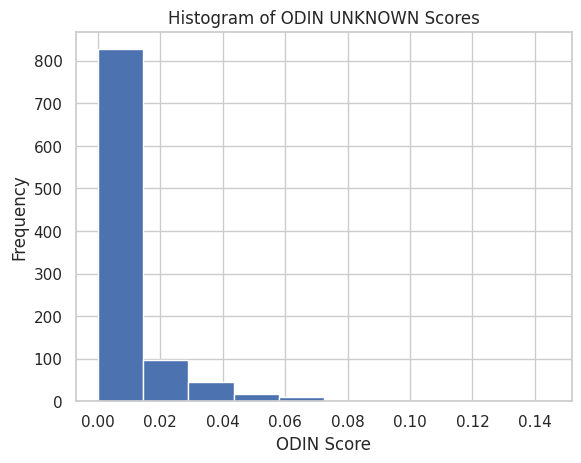

In [ ]:
plt.hist(odin_scores_for_models[0], bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN UNKNOWN Scores')

plt.show()

# ODIN score for one model, as an example

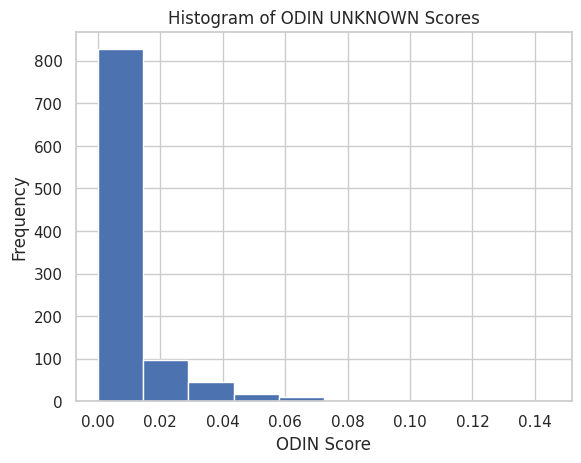

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001

UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

logits_layer = res_net01.layers[-2].output
logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

odin_scores_UN_KNOWN = []

batch_size = 32

for i in range(0, len(NeverSeen_data_X_test), batch_size):
    batch = UN_Known_data_X_test_as_tensor[i:i+batch_size]

    with tf.device("/CPU:0"):
        logits = logits_model(batch)

    with tf.GradientTape() as tape:
        tape.watch(batch)
        output = logits_model(batch)
    grads = tape.gradient(output, batch)

    signed_grads = tf.sign(grads)

    perturbed_spectra = batch + magnitude * signed_grads

    with tf.device("/CPU:0"):
        perturbed_logits = logits_model(perturbed_spectra)

    scaled_perturbed_logits = perturbed_logits / temperature

    perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

    max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

    max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
    odin_scores_batch = max_logits - max_perturbed_softmax_scores

    odin_scores_UN_KNOWN.extend(odin_scores_batch)

odin_scores_UN_KNOWN = np.array(odin_scores_UN_KNOWN)

plt.hist(odin_scores_UN_KNOWN, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN UNKNOWN Scores')

plt.show()


In [ ]:
min(odin_scores_UN_KNOWN)

0.00016625563

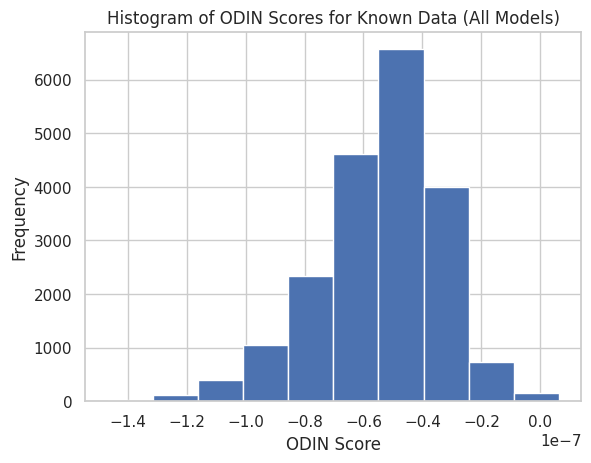

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
magnitude = 0.001
temperature = 1000
num_models = 20

loaded_models = [
    res_net01, res_net02, res_net03, res_net04, res_net05,
    res_net06, res_net07, res_net08, res_net09, res_net10,
    res_net11, res_net12, res_net13, res_net14, res_net15,
    res_net16, res_net17, res_net18, res_net19, res_net20
]

odin_scores_all_models = []

for i in range(num_models):
    logits_layer = loaded_models[i].layers[-2].output

    logits_model = tf.keras.Model(inputs=loaded_models[i].input, outputs=logits_layer)

    Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

    odin_scores_KNOWN = []

    for j in range(0, len(Known_data_X_test), batch_size):
        batch = Known_data_X_test_as_tensor[j:j+batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            logits = logits_model(batch)
        grads = tape.gradient(logits, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        original_softmax_output = tf.nn.softmax(logits / temperature)
        max_softmax_scores = tf.reduce_max(original_softmax_output, axis=1)

        odin_scores_batch = max_softmax_scores - max_perturbed_softmax_scores

        odin_scores_KNOWN.extend(odin_scores_batch)

    odin_scores_KNOWN = np.array(odin_scores_KNOWN)
    odin_scores_all_models.append(odin_scores_KNOWN)

combined_odin_scores = np.concatenate(odin_scores_all_models)

plt.hist(combined_odin_scores, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN Scores for Known Data (All Models)')

plt.show()


In [ ]:
import os

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "KNOWN_all_odin_scores_EOSp1p3.txt"

file_path = os.path.join(folder_path, file_name)

np.savetxt(file_path, combined_odin_scores, delimiter=',')


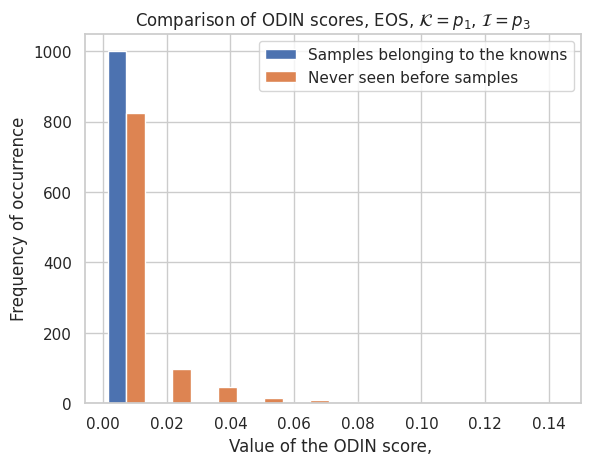

In [ ]:
plt.hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels

plt.xlabel('Value of the ODIN score, ')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of ODIN scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

# OpenMax score

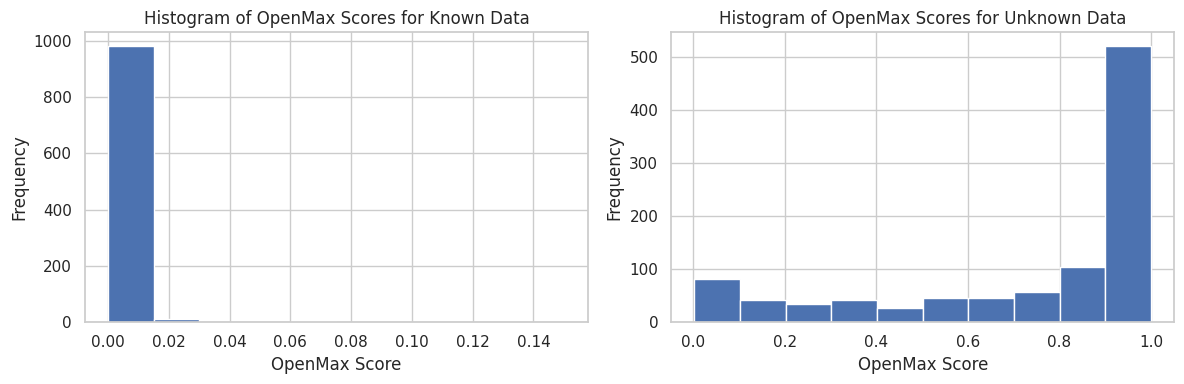

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

logits_layer = res_net01.layers[-2].output

logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

known_logits = logits_model(Known_data_X_test_as_tensor)
unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

max_known_logits = tf.reduce_max(known_logits, axis=1)
max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

def compute_openmax_scores_known(max_known_logits, alpha=1.0):
    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))
    return scores_known

openmax_scores_known = compute_openmax_scores_known(max_known_logits)

def compute_openmax_scores_unknown(max_known_logits, max_unknown_logits, alpha=1.0):
    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)
    return tf.stack(scores_unknown)

openmax_scores_unknown = compute_openmax_scores_unknown(max_known_logits, max_unknown_logits)

openmax_scores_known = openmax_scores_known.numpy()
openmax_scores_unknown = openmax_scores_unknown.numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(openmax_scores_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(openmax_scores_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()



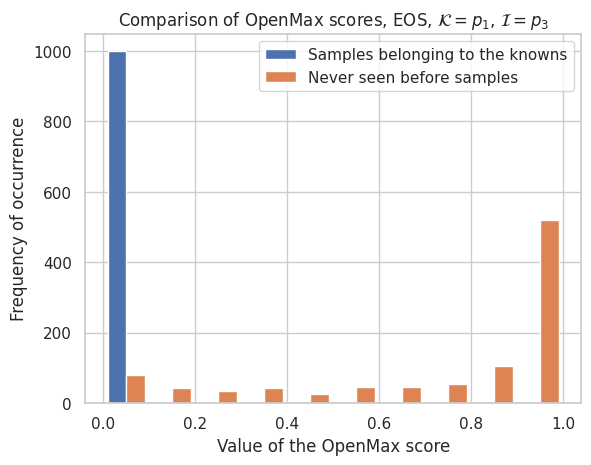

In [ ]:
plt.hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels

plt.xlabel('Value of the OpenMax score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of OpenMax scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

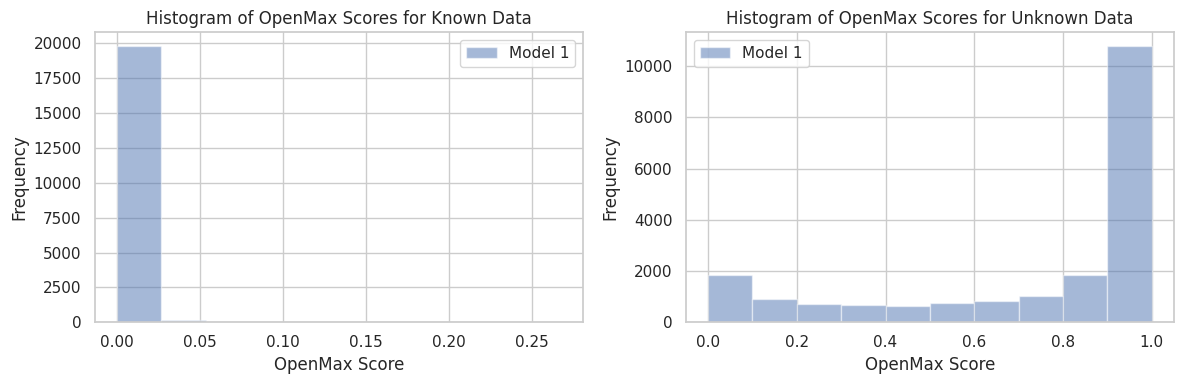

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.0
num_models = 20

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

openmax_scores_known = []
openmax_scores_unknown = []

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

for model in loaded_models:
    logits_layer = model.layers[-2].output

    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    known_logits = logits_model(Known_data_X_test_as_tensor)
    unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

    max_known_logits = tf.reduce_max(known_logits, axis=1)
    max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))

    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)

    openmax_scores_known.append(scores_known.numpy())
    openmax_scores_unknown.append(scores_unknown)

merged_openmax_scores_known = np.stack(openmax_scores_known, axis=1)
merged_openmax_scores_unknown = np.stack(openmax_scores_unknown, axis=1)

combined_openmax_scores_known = merged_openmax_scores_known.flatten()
combined_openmax_scores_unknown = merged_openmax_scores_unknown.flatten()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(combined_openmax_scores_known, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combined_openmax_scores_unknown, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt('/content/gdrive/MyDrive/Stanford_data/EOSp1p3_combined_openmax_scores_known.txt', combined_openmax_scores_known)
np.savetxt('/content/gdrive/MyDrive/Stanford_data/EOSp1p3_combined_openmax_scores_unknown.txt', combined_openmax_scores_unknown)


In [ ]:
min(openmax_scores_unknown)

0.002969627

In [ ]:
import numpy as np

openmax_scores_known_sorted = np.sort(openmax_scores_known)
openmax_scores_unknown_sorted = np.sort(openmax_scores_unknown)

min_known_score = openmax_scores_known_sorted.min()
max_known_score = openmax_scores_known_sorted.max()
min_unknown_score = openmax_scores_unknown_sorted.min()
max_unknown_score = openmax_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(openmax_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(openmax_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")


Overlap (IoU): 1.06%


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import distance
import tensorflow as tf

def preprocess_data(data):
    preprocessed_data = data
    return preprocessed_data

def extract_deep_features(model, data):
    preprocessed_data = preprocess_data(data)
    deep_features = model.layers[-2].output
    deep_feature_model = tf.keras.Model(inputs=model.input, outputs=deep_features)
    extracted_features = deep_feature_model.predict(preprocessed_data)

    return extracted_features

def reduce_dimensionality(features, n_components):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca

deep_features_known = extract_deep_features(res_net01, Known_data_X_test)
deep_features_unknown = extract_deep_features(res_net01, NeverSeen_data_X_test)

n_components = 100
reduced_features_known, pca_known = reduce_dimensionality(deep_features_known, n_components)
reduced_features_unknown, pca_unknown = reduce_dimensionality(deep_features_unknown, n_components)

mean_known = np.mean(reduced_features_known, axis=0)
cov_known = np.cov(reduced_features_known, rowvar=False)

cond_number = np.linalg.cond(cov_known)
print("Condition Number of Covariance Matrix (Known Data):", cond_number)

epsilon = 1e-2

if cond_number > 1 / epsilon:
    cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
else:
    cov_known_reg = cov_known

mahalanobis_distances_known = []
for feature in reduced_features_known:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_known.append(mahalanobis_distance)

mahalanobis_distances_unknown = []
for feature in reduced_features_unknown:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_unknown.append(mahalanobis_distance)

threshold_known = 3.0
threshold_unknown = 4.0

ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown) if distance > threshold_unknown]

print("Out-of-Distribution Sample Indices (Known Data):", ood_samples_known)
print("Out-of-Distribution Sample Indices (Unknown Data):", ood_samples_unknown)







32/32 [==============================] - 1s 18ms/step
Condition Number of Covariance Matrix (Known Data): 377.67054396436447
Out-of-Distribution Sample Indices (Known Data): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 

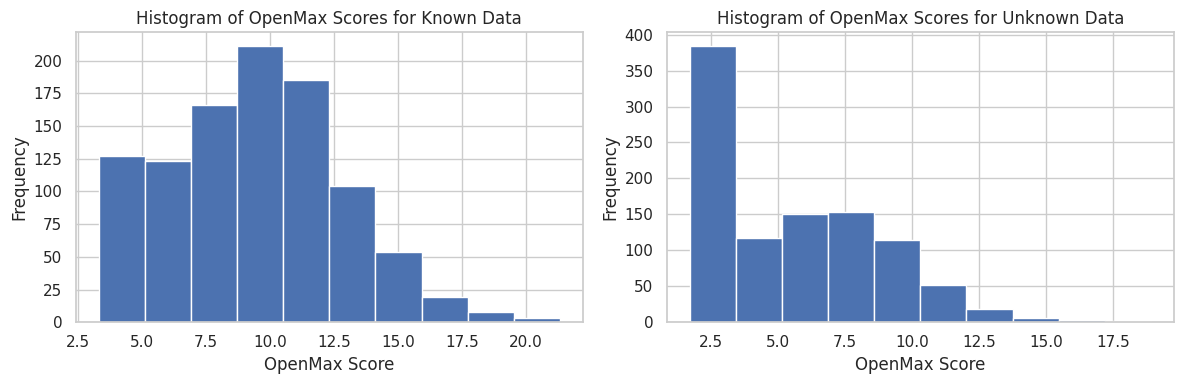

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()

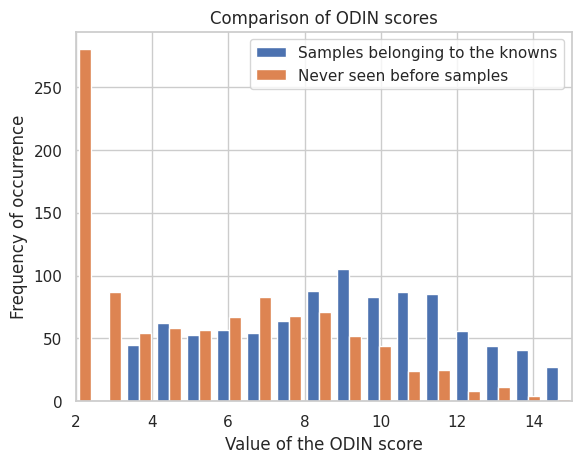

In [ ]:
plt.hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels
plt.xlim(2, 15)

plt.xlabel('Value of the ODIN score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of ODIN scores')

plt.legend()

plt.show()

In [ ]:
import numpy as np

mahalanobis_scores_known_sorted = np.sort(mahalanobis_distances_known)
mahalanobis_scores_unknown_sorted = np.sort(mahalanobis_distances_unknown)

min_known_score = mahalanobis_scores_known_sorted.min()
max_known_score = mahalanobis_scores_known_sorted.max()
min_unknown_score = mahalanobis_scores_unknown_sorted.min()
max_unknown_score = mahalanobis_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(mahalanobis_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(mahalanobis_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")

Overlap (IoU): 23.99%


32/32 [==============================] - 1s 18ms/step
Condition Number of Covariance Matrix (Known Data): 378.82457713264495
32/32 [==============================] - 2s 19ms/step
Condition Number of Covariance Matrix (Known Data): 356.5433511548209
32/32 [==============================] - 2s 18ms/step
Condition Number of Covariance Matrix (Known Data): 342.1158987229308
32/32 [==============================] - 1s 18ms/step
Condition Number of Covariance Matrix (Known Data): 388.5485618395704
32/32 [==============================] - 1s 19ms/step
Condition Number of Covariance Matrix (Known Data): 376.28152425759674
32/32 [==============================] - 1s 18ms/step
Condition Number of Covariance Matrix (Known Data): 403.3169394201868
32/32 [==============================] - 1s 18ms/step
Condition Number of Covariance Matrix (Known Data): 360.56808969227654
32/32 [==============================] - 1s 19ms/step
Condition Number of Covariance Matrix (Known Data): 350.0764376039229
32/32

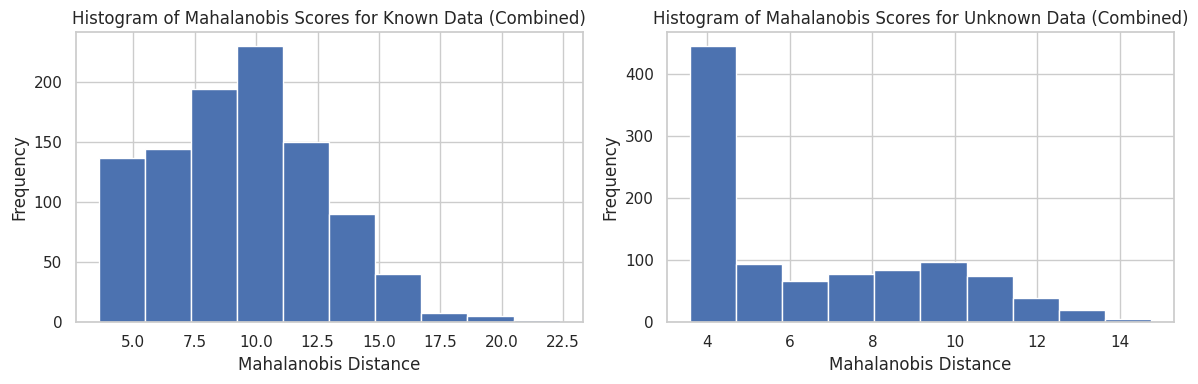

In [ ]:
import numpy as np
from scipy.spatial import distance
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

deep_features_known_all = []
mahalanobis_distances_known_all = []
deep_features_unknown_all = []
mahalanobis_distances_unknown_all = []

n_components = 100

for model in loaded_models:
    deep_features_known = extract_deep_features(model, Known_data_X_test)
    deep_features_unknown = extract_deep_features(model, NeverSeen_data_X_test)

    pca = PCA(n_components=n_components)
    deep_features_known_pca = pca.fit_transform(deep_features_known)
    deep_features_unknown_pca = pca.transform(deep_features_unknown)

    mean_known = np.mean(deep_features_known_pca, axis=0)
    cov_known = np.cov(deep_features_known_pca, rowvar=False)

    cond_number = np.linalg.cond(cov_known)
    print("Condition Number of Covariance Matrix (Known Data):", cond_number)

    epsilon = 1e-5

    if cond_number > 1 / epsilon:
        cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
    else:
        cov_known_reg = cov_known

    mahalanobis_distances_known = []
    for feature in deep_features_known_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_known.append(mahalanobis_distance)

    mahalanobis_distances_unknown = []
    for feature in deep_features_unknown_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_unknown.append(mahalanobis_distance)

    deep_features_known_all.append(deep_features_known_pca)
    mahalanobis_distances_known_all.append(mahalanobis_distances_known)
    deep_features_unknown_all.append(deep_features_unknown_pca)
    mahalanobis_distances_unknown_all.append(mahalanobis_distances_unknown)

deep_features_known_combined = np.concatenate(deep_features_known_all, axis=-1)
mahalanobis_distances_known_combined = np.mean(mahalanobis_distances_known_all, axis=0)

deep_features_unknown_combined = np.concatenate(deep_features_unknown_all, axis=-1)
mahalanobis_distances_unknown_combined = np.mean(mahalanobis_distances_unknown_all, axis=0)

threshold_known = 3.0
threshold_unknown = 4.0

ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known_combined) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown_combined) if distance > threshold_unknown]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Known Data (Combined)')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Unknown Data (Combined)')

plt.tight_layout()
plt.show()



In [ ]:
np.savetxt(f'{folder_path}/mahalanobis_distances_known_combined_EOSp1p3.txt', mahalanobis_distances_known_combined)
np.savetxt(f'{folder_path}/mahalanobis_distances_unknown_combined_EOSp1p3.txt', mahalanobis_distances_unknown_combined)

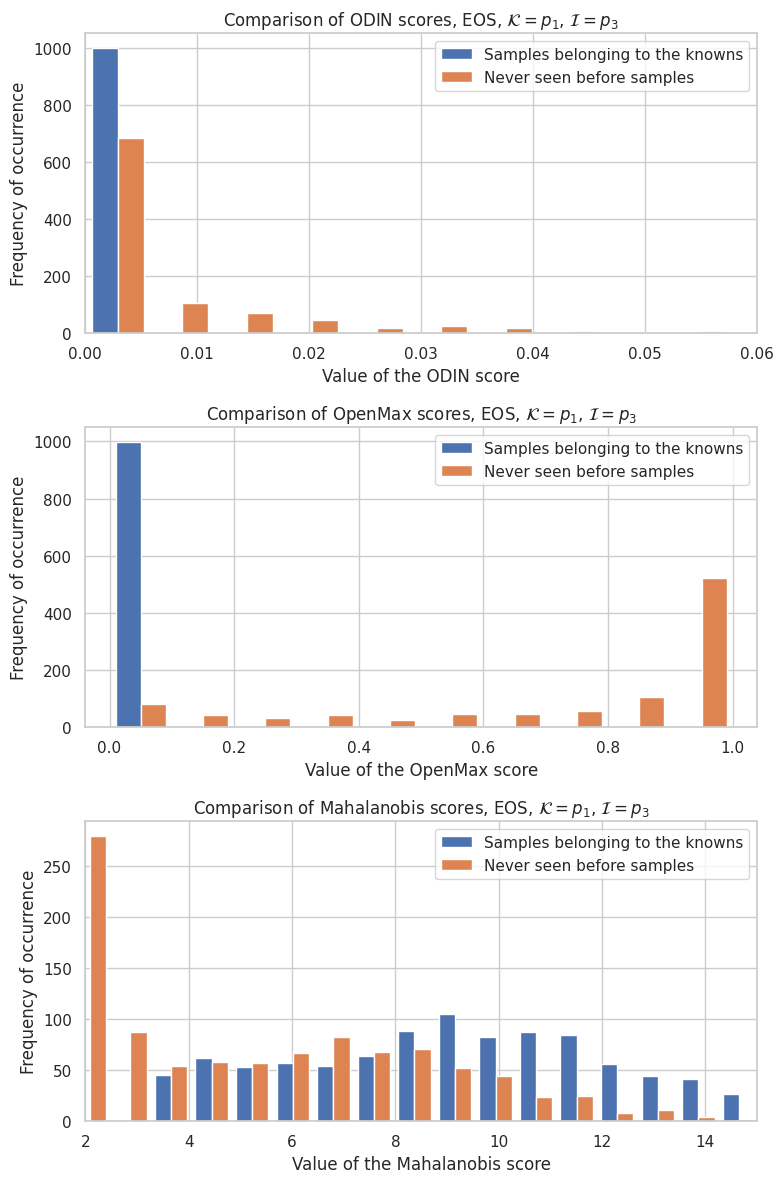

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()

axs[0].set_xlim(0, 0.06)

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()

axs[2].set_xlim(2, 15)

plt.tight_layout()

plt.show()


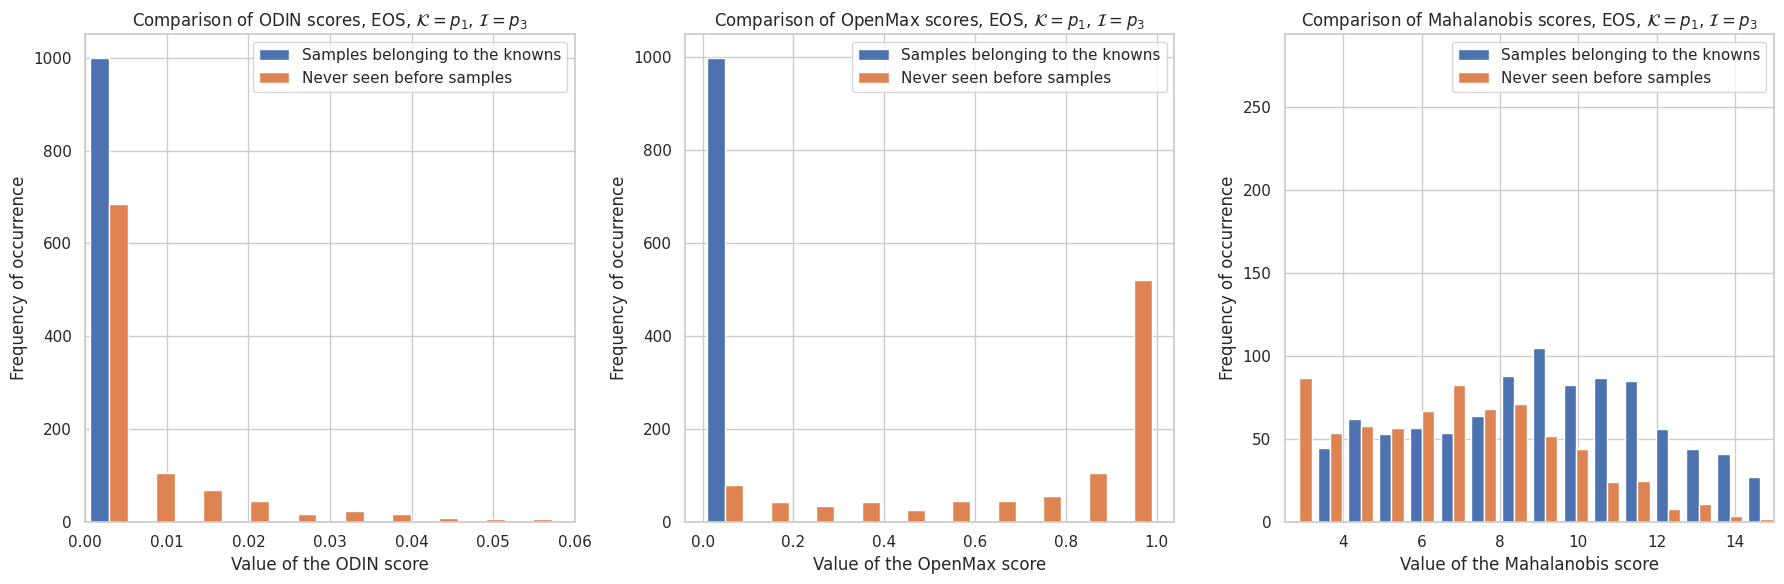

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()
axs[0].set_xlim(0, 0.06)

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, EOS, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()
axs[2].set_xlim(2.5, 15)

plt.tight_layout()

plt.show()



In [ ]:
Known_data_X_test_label_int = []
for i in range(Known_data_X_test_label.shape[0]):
  Known_data_X_test_label_int.append(np.argmax(Known_data_X_test_label[i]))

In [ ]:
prediction_known_ensemble_1 = (prediction01_known + prediction02_known + prediction03_known + prediction04_known + prediction05_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_1.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the first ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_2 = (prediction06_known + prediction07_known + prediction08_known + prediction09_known + prediction10_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_2.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the second ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_3 = (prediction11_known + prediction12_known + prediction13_known + prediction14_known + prediction15_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_3.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the third ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_4 = (prediction16_known + prediction17_known + prediction18_known + prediction19_known + prediction20_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_4.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the fourth ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

Accuracy of the first ensemble on the knowns 0.897
Accuracy of the second ensemble on the knowns 0.9
Accuracy of the third ensemble on the knowns 0.899
Accuracy of the fourth ensemble on the knowns 0.907


# Separating $\mathcal{K}$ and $\mathcal{N}$ by a fixed (class-independendent) threshold

In [ ]:
prediction_known = prediction_known_ensemble_3
prediction_unknown = prediction_unknown_ensemble_3

In [ ]:
def thresholding(threshold):
  true = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] == Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      true += 1
  return true/(prediction_known.shape[0])

In [ ]:
CorrectThresholding = []
for i in range(90):
  CorrectThresholding.append([0.1 + 0.01*i,100*thresholding(0.1 + 0.01*i)])
for i in range(10):
  CorrectThresholding.append([0.99 + 0.001*i,100*thresholding(0.99 + 0.001*i)])
CorrectThresholding

[[0.1, 89.9],
 [0.11, 89.9],
 [0.12000000000000001, 89.9],
 [0.13, 89.9],
 [0.14, 89.8],
 [0.15000000000000002, 89.8],
 [0.16, 89.7],
 [0.17, 89.60000000000001],
 [0.18, 89.60000000000001],
 [0.19, 89.5],
 [0.2, 89.5],
 [0.21000000000000002, 89.4],
 [0.22, 89.3],
 [0.23, 89.3],
 [0.24000000000000002, 89.2],
 [0.25, 89.0],
 [0.26, 88.8],
 [0.27, 88.8],
 [0.28, 88.6],
 [0.29000000000000004, 88.6],
 [0.30000000000000004, 88.6],
 [0.31, 88.3],
 [0.32, 88.2],
 [0.33, 88.1],
 [0.33999999999999997, 88.1],
 [0.35, 87.8],
 [0.36, 87.6],
 [0.37, 87.6],
 [0.38, 87.5],
 [0.39, 87.4],
 [0.4, 87.4],
 [0.41000000000000003, 87.3],
 [0.42000000000000004, 87.0],
 [0.43000000000000005, 86.8],
 [0.44000000000000006, 86.7],
 [0.45000000000000007, 86.6],
 [0.45999999999999996, 86.1],
 [0.47, 86.1],
 [0.48, 85.9],
 [0.49, 85.8],
 [0.5, 85.6],
 [0.51, 85.3],
 [0.52, 85.0],
 [0.53, 84.89999999999999],
 [0.54, 84.6],
 [0.55, 84.39999999999999],
 [0.56, 84.39999999999999],
 [0.5700000000000001, 83.89999999999999

In [ ]:
def false_identify(threshold):
  false_identify = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] != Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      false_identify += 1
  return false_identify/(prediction_known.shape[0])

In [ ]:
FalseIdentify = []
for i in range(90):
  FalseIdentify.append([0.1 + 0.01*i,100*false_identify(0.1 + 0.01*i)])
for i in range(10):
  FalseIdentify.append([0.99 + 0.001*i,100*false_identify(0.99 + 0.001*i)])
FalseIdentify

[[0.1, 10.100000000000001],
 [0.11, 10.100000000000001],
 [0.12000000000000001, 10.100000000000001],
 [0.13, 10.100000000000001],
 [0.14, 10.0],
 [0.15000000000000002, 9.9],
 [0.16, 9.9],
 [0.17, 9.8],
 [0.18, 9.8],
 [0.19, 9.8],
 [0.2, 9.700000000000001],
 [0.21000000000000002, 9.4],
 [0.22, 9.3],
 [0.23, 9.3],
 [0.24000000000000002, 9.3],
 [0.25, 9.3],
 [0.26, 9.2],
 [0.27, 9.2],
 [0.28, 9.2],
 [0.29000000000000004, 8.9],
 [0.30000000000000004, 8.9],
 [0.31, 8.9],
 [0.32, 8.9],
 [0.33, 8.799999999999999],
 [0.33999999999999997, 8.799999999999999],
 [0.35, 8.799999999999999],
 [0.36, 8.7],
 [0.37, 8.7],
 [0.38, 8.7],
 [0.39, 8.6],
 [0.4, 8.5],
 [0.41000000000000003, 8.5],
 [0.42000000000000004, 8.1],
 [0.43000000000000005, 7.8],
 [0.44000000000000006, 7.5],
 [0.45000000000000007, 7.5],
 [0.45999999999999996, 7.199999999999999],
 [0.47, 7.199999999999999],
 [0.48, 7.000000000000001],
 [0.49, 6.9],
 [0.5, 6.4],
 [0.51, 6.3],
 [0.52, 6.2],
 [0.53, 6.1],
 [0.54, 6.1],
 [0.55, 6.0],
 [0.56

In [ ]:
def misclassifyunknown(threshold):
  misclassifyunknown = 0
  for i in range(prediction_unknown.shape[0]):
    if max(prediction_unknown[i]) > threshold:
      misclassifyunknown += 1
  return misclassifyunknown/(prediction_unknown.shape[0])

In [ ]:
UnknownMisclassify = []
for i in range(90):
  UnknownMisclassify.append([0.1 + 0.01*i,100*misclassifyunknown(0.1 + 0.01*i)])
for i in range(10):
  UnknownMisclassify.append([0.99 + 0.001*i,100*misclassifyunknown(0.99 + 0.001*i)])
UnknownMisclassify

[[0.1, 100.0],
 [0.11, 100.0],
 [0.12000000000000001, 99.7],
 [0.13, 96.39999999999999],
 [0.14, 89.7],
 [0.15000000000000002, 83.6],
 [0.16, 78.7],
 [0.17, 74.2],
 [0.18, 71.6],
 [0.19, 69.8],
 [0.2, 67.9],
 [0.21000000000000002, 67.2],
 [0.22, 65.9],
 [0.23, 64.7],
 [0.24000000000000002, 63.6],
 [0.25, 62.7],
 [0.26, 62.1],
 [0.27, 61.199999999999996],
 [0.28, 60.4],
 [0.29000000000000004, 59.8],
 [0.30000000000000004, 58.9],
 [0.31, 58.199999999999996],
 [0.32, 57.599999999999994],
 [0.33, 56.699999999999996],
 [0.33999999999999997, 55.900000000000006],
 [0.35, 55.60000000000001],
 [0.36, 54.900000000000006],
 [0.37, 54.300000000000004],
 [0.38, 53.5],
 [0.39, 52.400000000000006],
 [0.4, 52.1],
 [0.41000000000000003, 51.5],
 [0.42000000000000004, 50.7],
 [0.43000000000000005, 49.9],
 [0.44000000000000006, 49.7],
 [0.45000000000000007, 48.699999999999996],
 [0.45999999999999996, 48.4],
 [0.47, 47.4],
 [0.48, 46.9],
 [0.49, 45.9],
 [0.5, 45.1],
 [0.51, 44.6],
 [0.52, 44.0],
 [0.53, 43

In [ ]:
def dontknow(threshold):
  notknown = 0
  for i in range(prediction_known.shape[0]):
    if max(prediction_known[i]) <= threshold:
      notknown += 1
  return notknown/(prediction_known.shape[0])

In [ ]:
DontKnowThresholding = []
for i in range(90):
  DontKnowThresholding.append([0.1 + 0.01*i,100*dontknow(0.1 + 0.01*i)])
for i in range(10):
  DontKnowThresholding.append([0.99 + 0.001*i,100*dontknow(0.99 + 0.001*i)])
DontKnowThresholding

[[0.1, 0.0],
 [0.11, 0.0],
 [0.12000000000000001, 0.0],
 [0.13, 0.0],
 [0.14, 0.2],
 [0.15000000000000002, 0.3],
 [0.16, 0.4],
 [0.17, 0.6],
 [0.18, 0.6],
 [0.19, 0.7000000000000001],
 [0.2, 0.8],
 [0.21000000000000002, 1.2],
 [0.22, 1.4000000000000001],
 [0.23, 1.4000000000000001],
 [0.24000000000000002, 1.5],
 [0.25, 1.7000000000000002],
 [0.26, 2.0],
 [0.27, 2.0],
 [0.28, 2.1999999999999997],
 [0.29000000000000004, 2.5],
 [0.30000000000000004, 2.5],
 [0.31, 2.8000000000000003],
 [0.32, 2.9000000000000004],
 [0.33, 3.1],
 [0.33999999999999997, 3.1],
 [0.35, 3.4000000000000004],
 [0.36, 3.6999999999999997],
 [0.37, 3.6999999999999997],
 [0.38, 3.8],
 [0.39, 4.0],
 [0.4, 4.1000000000000005],
 [0.41000000000000003, 4.2],
 [0.42000000000000004, 4.9],
 [0.43000000000000005, 5.4],
 [0.44000000000000006, 5.800000000000001],
 [0.45000000000000007, 5.8999999999999995],
 [0.45999999999999996, 6.7],
 [0.47, 6.7],
 [0.48, 7.1],
 [0.49, 7.3],
 [0.5, 8.0],
 [0.51, 8.4],
 [0.52, 8.799999999999999],

In [ ]:
aligned_array = [element for row in prediction_unknown for element in row]
# Find the maximum value in the aligned array
max_value = max(aligned_array)

# The max_value variable now contains the maximum value in the aligned array
print("The maximum value in the aligned array is:", max_value)


The maximum value in the aligned array is: 0.99999845


In [ ]:
thresholding(max_value)

0.029

In [ ]:
thresholding(0)

0.899

In [ ]:
dontknow(max_value)

0.971

In [ ]:
misclassifyunknown(max_value)

0.0

In [ ]:
false_identify(max_value)

0.0

In [ ]:
DontKnowThresholdingANOTHER = []

for i in range(89):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.1 + 0.01*i),100*dontknow(0.1 + 0.01*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99 + 0.001*i),100*dontknow(0.99 + 0.001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*dontknow(0.999 + 0.0001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*dontknow(0.9999 + 0.00001*i),])

for i in range(9):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*dontknow(0.99999 + 0.000001*i),])

DontKnowThresholdingANOTHER.append([100*thresholding(max_value),100*dontknow(max_value)])

DontKnowThresholdingANOTHER

[[89.9, 0.0],
 [89.9, 0.0],
 [89.9, 0.0],
 [89.9, 0.0],
 [89.8, 0.2],
 [89.8, 0.3],
 [89.7, 0.4],
 [89.60000000000001, 0.6],
 [89.60000000000001, 0.6],
 [89.5, 0.7000000000000001],
 [89.5, 0.8],
 [89.4, 1.2],
 [89.3, 1.4000000000000001],
 [89.3, 1.4000000000000001],
 [89.2, 1.5],
 [89.0, 1.7000000000000002],
 [88.8, 2.0],
 [88.8, 2.0],
 [88.6, 2.1999999999999997],
 [88.6, 2.5],
 [88.6, 2.5],
 [88.3, 2.8000000000000003],
 [88.2, 2.9000000000000004],
 [88.1, 3.1],
 [88.1, 3.1],
 [87.8, 3.4000000000000004],
 [87.6, 3.6999999999999997],
 [87.6, 3.6999999999999997],
 [87.5, 3.8],
 [87.4, 4.0],
 [87.4, 4.1000000000000005],
 [87.3, 4.2],
 [87.0, 4.9],
 [86.8, 5.4],
 [86.7, 5.800000000000001],
 [86.6, 5.8999999999999995],
 [86.1, 6.7],
 [86.1, 6.7],
 [85.9, 7.1],
 [85.8, 7.3],
 [85.6, 8.0],
 [85.3, 8.4],
 [85.0, 8.799999999999999],
 [84.89999999999999, 9.0],
 [84.6, 9.3],
 [84.39999999999999, 9.6],
 [84.39999999999999, 9.700000000000001],
 [83.89999999999999, 10.299999999999999],
 [83.3, 10.9]

In [ ]:
UnknownMisclassifyANOTHER = []
for i in range(89):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*misclassifyunknown(0.1 + 0.01*i),])
for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*misclassifyunknown(0.99 + 0.001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*misclassifyunknown(0.999 + 0.0001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*misclassifyunknown(0.9999 + 0.00001*i),])

for i in range(9):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*misclassifyunknown(0.99999 + 0.000001*i),])

UnknownMisclassifyANOTHER.append([100*thresholding(max_value),100*misclassifyunknown(max_value),])

UnknownMisclassifyANOTHER

[[89.9, 100.0],
 [89.9, 100.0],
 [89.9, 99.7],
 [89.9, 96.39999999999999],
 [89.8, 89.7],
 [89.8, 83.6],
 [89.7, 78.7],
 [89.60000000000001, 74.2],
 [89.60000000000001, 71.6],
 [89.5, 69.8],
 [89.5, 67.9],
 [89.4, 67.2],
 [89.3, 65.9],
 [89.3, 64.7],
 [89.2, 63.6],
 [89.0, 62.7],
 [88.8, 62.1],
 [88.8, 61.199999999999996],
 [88.6, 60.4],
 [88.6, 59.8],
 [88.6, 58.9],
 [88.3, 58.199999999999996],
 [88.2, 57.599999999999994],
 [88.1, 56.699999999999996],
 [88.1, 55.900000000000006],
 [87.8, 55.60000000000001],
 [87.6, 54.900000000000006],
 [87.6, 54.300000000000004],
 [87.5, 53.5],
 [87.4, 52.400000000000006],
 [87.4, 52.1],
 [87.3, 51.5],
 [87.0, 50.7],
 [86.8, 49.9],
 [86.7, 49.7],
 [86.6, 48.699999999999996],
 [86.1, 48.4],
 [86.1, 47.4],
 [85.9, 46.9],
 [85.8, 45.9],
 [85.6, 45.1],
 [85.3, 44.6],
 [85.0, 44.0],
 [84.89999999999999, 43.7],
 [84.6, 42.9],
 [84.39999999999999, 42.4],
 [84.39999999999999, 41.699999999999996],
 [83.89999999999999, 40.8],
 [83.3, 39.900000000000006],
 [83.

In [ ]:
FalseIdentifyANOTHER = []
for i in range(89):
  FalseIdentifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*false_identify(0.1 + 0.01*i),])
for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*false_identify(0.99 + 0.001*i)])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*false_identify(0.999 + 0.0001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*false_identify(0.9999 + 0.00001*i),])

for i in range(9):
  FalseIdentifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*false_identify(0.99999 + 0.000001*i),])

FalseIdentifyANOTHER.append([100*thresholding(max_value),100*false_identify(max_value),])
FalseIdentifyANOTHER

[[89.9, 10.100000000000001],
 [89.9, 10.100000000000001],
 [89.9, 10.100000000000001],
 [89.9, 10.100000000000001],
 [89.8, 10.0],
 [89.8, 9.9],
 [89.7, 9.9],
 [89.60000000000001, 9.8],
 [89.60000000000001, 9.8],
 [89.5, 9.8],
 [89.5, 9.700000000000001],
 [89.4, 9.4],
 [89.3, 9.3],
 [89.3, 9.3],
 [89.2, 9.3],
 [89.0, 9.3],
 [88.8, 9.2],
 [88.8, 9.2],
 [88.6, 9.2],
 [88.6, 8.9],
 [88.6, 8.9],
 [88.3, 8.9],
 [88.2, 8.9],
 [88.1, 8.799999999999999],
 [88.1, 8.799999999999999],
 [87.8, 8.799999999999999],
 [87.6, 8.7],
 [87.6, 8.7],
 [87.5, 8.7],
 [87.4, 8.6],
 [87.4, 8.5],
 [87.3, 8.5],
 [87.0, 8.1],
 [86.8, 7.8],
 [86.7, 7.5],
 [86.6, 7.5],
 [86.1, 7.199999999999999],
 [86.1, 7.199999999999999],
 [85.9, 7.000000000000001],
 [85.8, 6.9],
 [85.6, 6.4],
 [85.3, 6.3],
 [85.0, 6.2],
 [84.89999999999999, 6.1],
 [84.6, 6.1],
 [84.39999999999999, 6.0],
 [84.39999999999999, 5.8999999999999995],
 [83.89999999999999, 5.800000000000001],
 [83.3, 5.800000000000001],
 [83.1, 5.800000000000001],
 [82.5

# Class-adaptive threshold

# Run #1

In [ ]:
prediction_known = prediction_known_ensemble_1
prediction_unknown = prediction_unknown_ensemble_1

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(10):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

2

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

63

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

13

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

299
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[299])] = max(prediction_known[299])

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

94

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

335
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[335])] = max(prediction_known[335])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

71

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

403
495
499
Number of mistakes in this class: 3


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[495])] = max(prediction_known[495])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

99

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

592
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[592])] = max(prediction_known[592])

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and ThresholdNeverSeenBefores[5] > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

4

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

611
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[611])] = max(prediction_known[611])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

75

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

744
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[744])] = max(prediction_known[744])

In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

42

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

860
888
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[888])] = max(prediction_known[888])

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

98

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0



In [ ]:
FinalDistributionOver10ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun1

[[1, 2],
 [2, 63],
 [3, 13],
 [4, 73],
 [5, 42],
 [6, 99],
 [7, 4],
 [8, 26],
 [9, 42],
 [10, 98]]

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7, mistake8, mistake9]
NumberOfMistakesAfterThrAdj

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Average over 10 classes

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.462

# Average dataset

In [ ]:
import numpy as np

all_datasets = [FinalDistributionOver10ClassesRun1, FinalDistributionOver10ClassesRun2, FinalDistributionOver10ClassesRun3, FinalDistributionOver10ClassesRun4]

new_dataset = []

for x_value in range(1, 11):
    y_values = []

    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    new_dataset.append([x_value, avg_y, std_y])

for data_point in new_dataset:
    print(data_point)


[1, 2.0, 1.224744871391589]
[2, 66.25, 2.5860201081971503]
[3, 9.75, 3.112474899497183]
[4, 74.75, 1.0897247358851685]
[5, 42.5, 3.278719262151]
[6, 99.0, 0.0]
[7, 4.25, 0.82915619758885]
[8, 25.25, 5.539629951540085]
[9, 46.0, 10.295630140987]
[10, 96.75, 1.6393596310755]


In [ ]:
new_dataset

[[1, 2.0, 1.224744871391589],
 [2, 66.25, 2.5860201081971503],
 [3, 9.75, 3.112474899497183],
 [4, 74.75, 1.0897247358851685],
 [5, 42.5, 3.278719262151],
 [6, 99.0, 0.0],
 [7, 4.25, 0.82915619758885],
 [8, 25.25, 5.539629951540085],
 [9, 46.0, 10.295630140987],
 [10, 96.75, 1.6393596310755]]